# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [1]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

bash: /home/kb/anaconda3/envs/pytorch/lib/libtinfo.so.6: no version information available (required by bash)


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [2]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, color_encode = colors,index=None,overlap=False):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, color_encode).astype(numpy.uint8)

    # aggregate images and save
    if overlap:
        alpha = 0.65
        im_vis = np.zeros(img.shape,dtype=img.dtype)
        im_vis[:,:,:] = (alpha * img[:,:,:]) + ((1-alpha) * pred_color[:,:,:])
    else:
        im_vis = numpy.concatenate((img, pred_color), axis=1)
    return PIL.Image.fromarray(im_vis)
    #display(PIL.Image.fromarray(im_vis))

def visualize_input(source_img,immov_ob_img,mov_ob_img,misc_img,ground_img):
    im_immov = numpy.concatenate((source_img,immov_ob_img), axis=1)
    im_ground = numpy.concatenate((source_img,ground_img), axis=1)
    im_mov = numpy.concatenate((source_img,mov_ob_img), axis=1)
    im_misc = numpy.concatenate((source_img,misc_img), axis=1)
    print("Immovable Objects:")
    display(PIL.Image.fromarray(im_immov))
    print("Ground:")
    display(PIL.Image.fromarray(im_ground))
    print("Movable Objets:")
    display(PIL.Image.fromarray(im_mov))
    print("MISC Objects:")
    display(PIL.Image.fromarray(im_misc))
    

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [74]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='MobileNetV2dilated',
    fc_dim=320,
    weights='ckpt/ade20k-mobilenetv2dilated-c1_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='C1_deepsup',
    fc_dim=320,
    num_class=150,
    weights='ckpt/ade20k-mobilenetv2dilated-c1_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): MobileNetV2Dilated(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): SynchronizedBatchNorm2d(32, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): SynchronizedBatchNorm2d(32, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): SynchronizedBatchNorm2d(16, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): 

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [4]:
img_path = "/mnt/c/ros_converted/8/_Color_1699567283352.51806640625000.png"

In [4]:
class Images():
    def __init__(self,img_dir):
        self.img_dir = img_dir
        self.compose = pil_to_tensor = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
                std=[0.229, 0.224, 0.225])  # across a large photo dataset.
        ])
    def __len__(self):
        return sum([len(os.listdir(self.img_dir + "/" + i)) for i in os.listdir(self.img_dir)])
    def __getitem__(self, id):
        video_no,index = map(str,id)
        #print(video_no,index)
        path = self.img_dir + "/" + video_no + "/"
        path = path + os.listdir(path)[int(index)]
        pil_image = PIL.Image.open(path).convert('RGB')
        img_original = numpy.array(pil_image)
        img_data = self.compose(pil_image)
        singleton_batch = {'img_data': img_data[None].cuda()}
        return img_original,singleton_batch
            

In [5]:
class Annotate_img():
    def __init__(self,img_dir):
        self.img_dir = img_dir
        self.compose = pil_to_tensor = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
                std=[0.229, 0.224, 0.225])  # across a large photo dataset.
        ])
        
    def __len__(self):
        return len(list(os.listdir(self.img_dir)))
                    
    def zeros_calc(self,h,w,img_path):
        if not os.path.exists(img_path):
            img = np.zeros((h,w,3),dtype=np.uint8)
        else:
            img = PIL.Image.open(img_path).convert('RGB')
            img = np.array(img)
        return img
    
    def __getitem__(self, id):
        path = self.img_dir + "/" + str(id + 2) + "/"
        source_img_path = path + str(id + 2) + ".png"
        ground = path + "annotations/ground.png"
        immov = path + "annotations/immov_obstacles.png"
        mov = path + "annotations/movable_obstacles.png"
        misc = path + "annotations/misc.png"
        
        pil_image = PIL.Image.open(source_img_path).convert('RGB')
        w,h = pil_image.size
        img_original = np.array(pil_image)
        img_data = self.compose(pil_image)
        singleton_batch = {'img_data': img_data[None].cuda()}
        
        ground = self.zeros_calc(h,w,ground)
        immov = self.zeros_calc(h,w,immov)
        mov = self.zeros_calc(h,w,mov)
        misc = self.zeros_calc(h,w,misc)
        
        return img_original,singleton_batch,ground,immov,mov,misc
   
            

here (720, 1280, 3) (720, 1280, 3) (720, 1280, 3) (720, 1280, 3) (720, 1280, 3)
Immovable Objects:


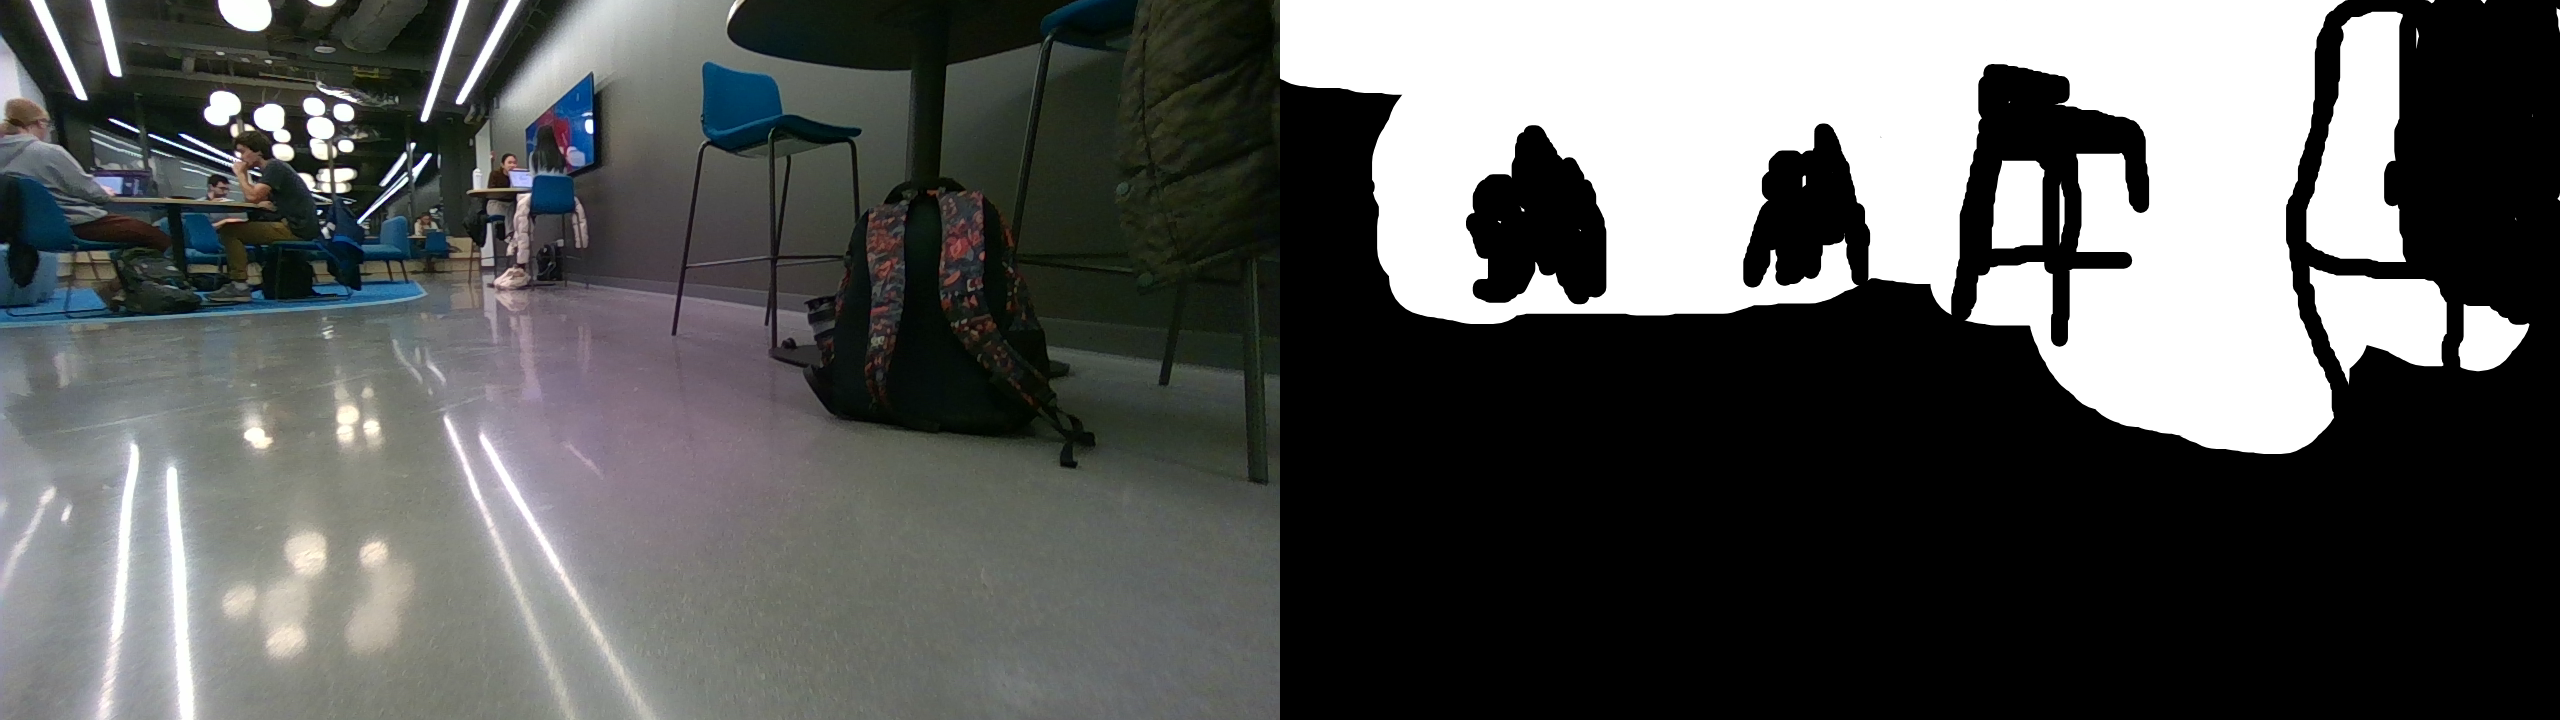

Ground:


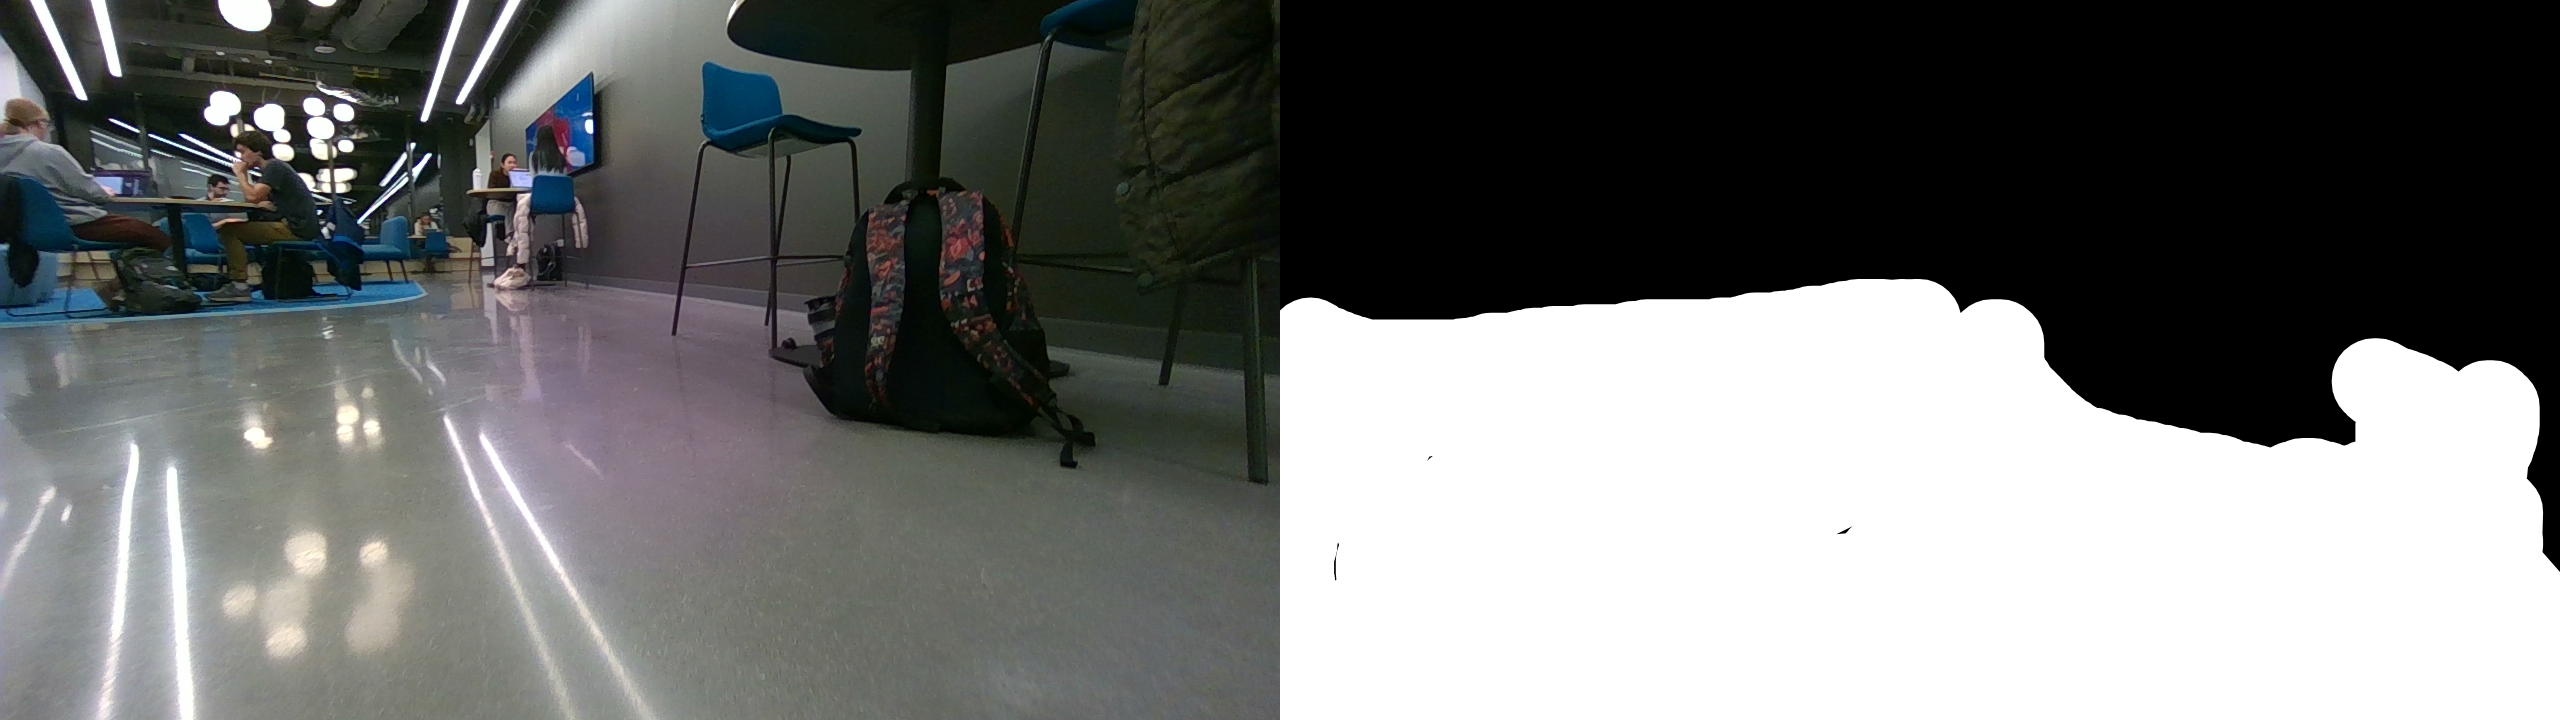

Movable Objets:


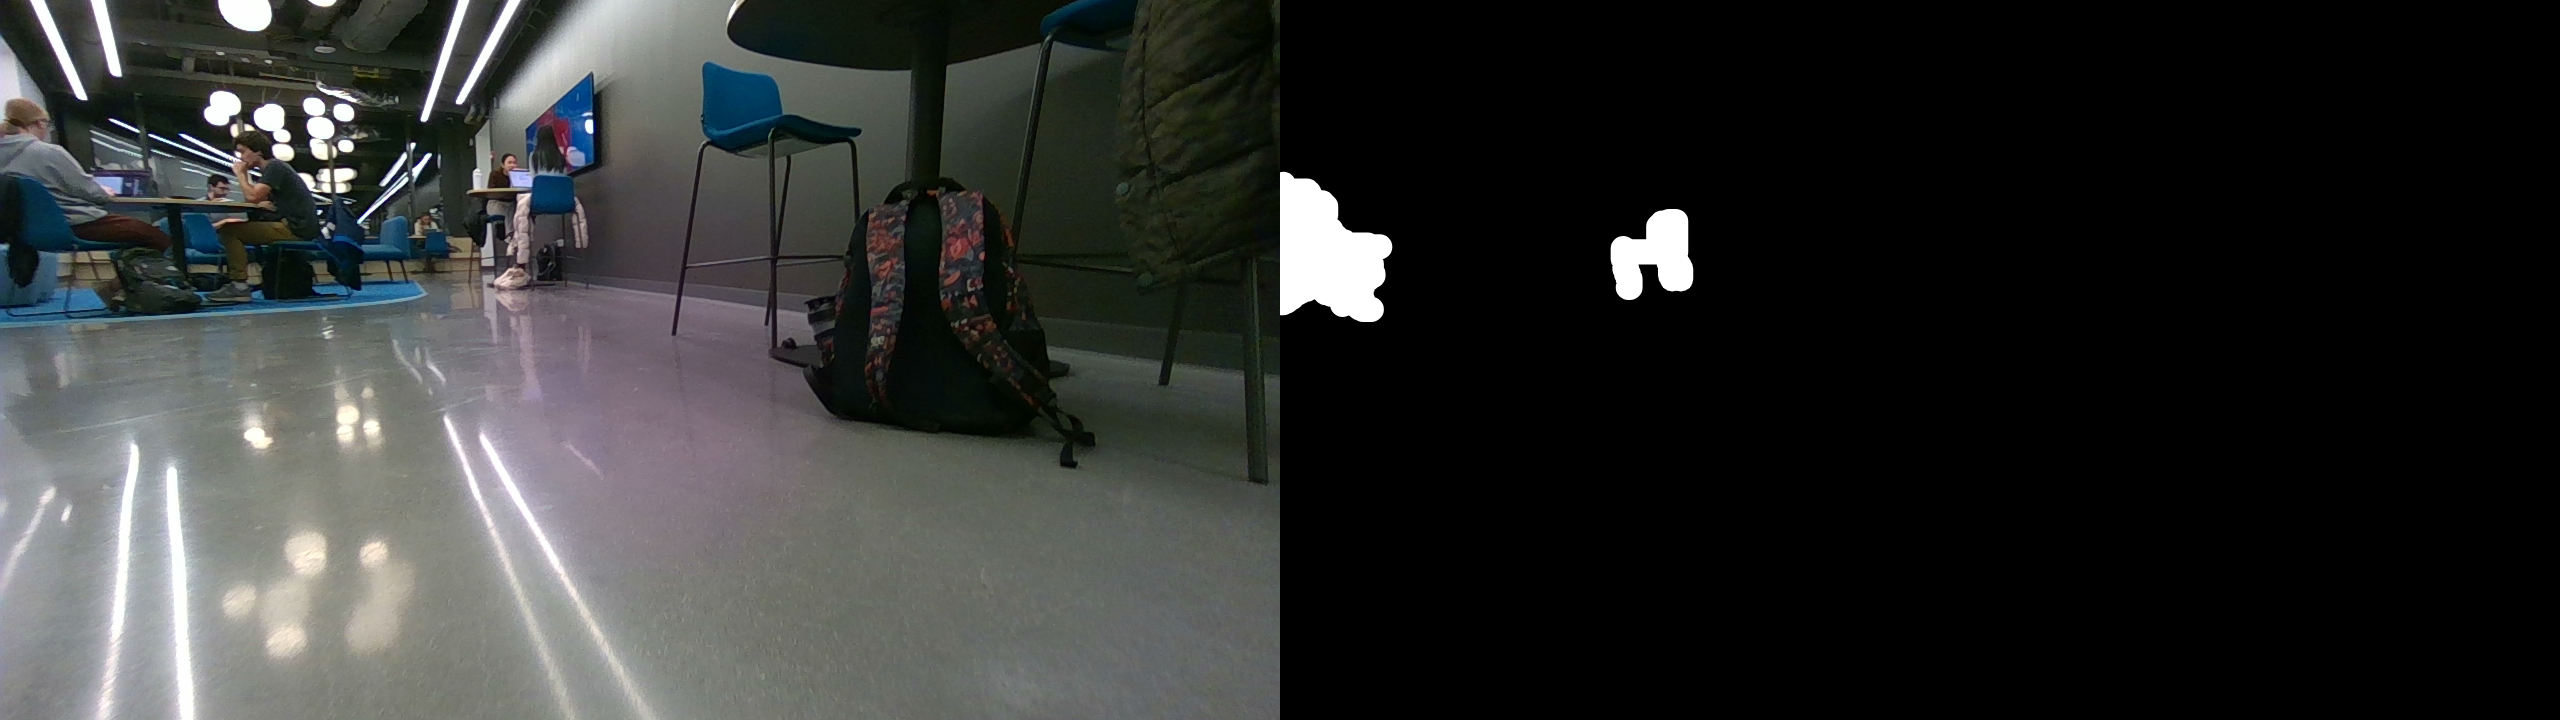

MISC Objects:


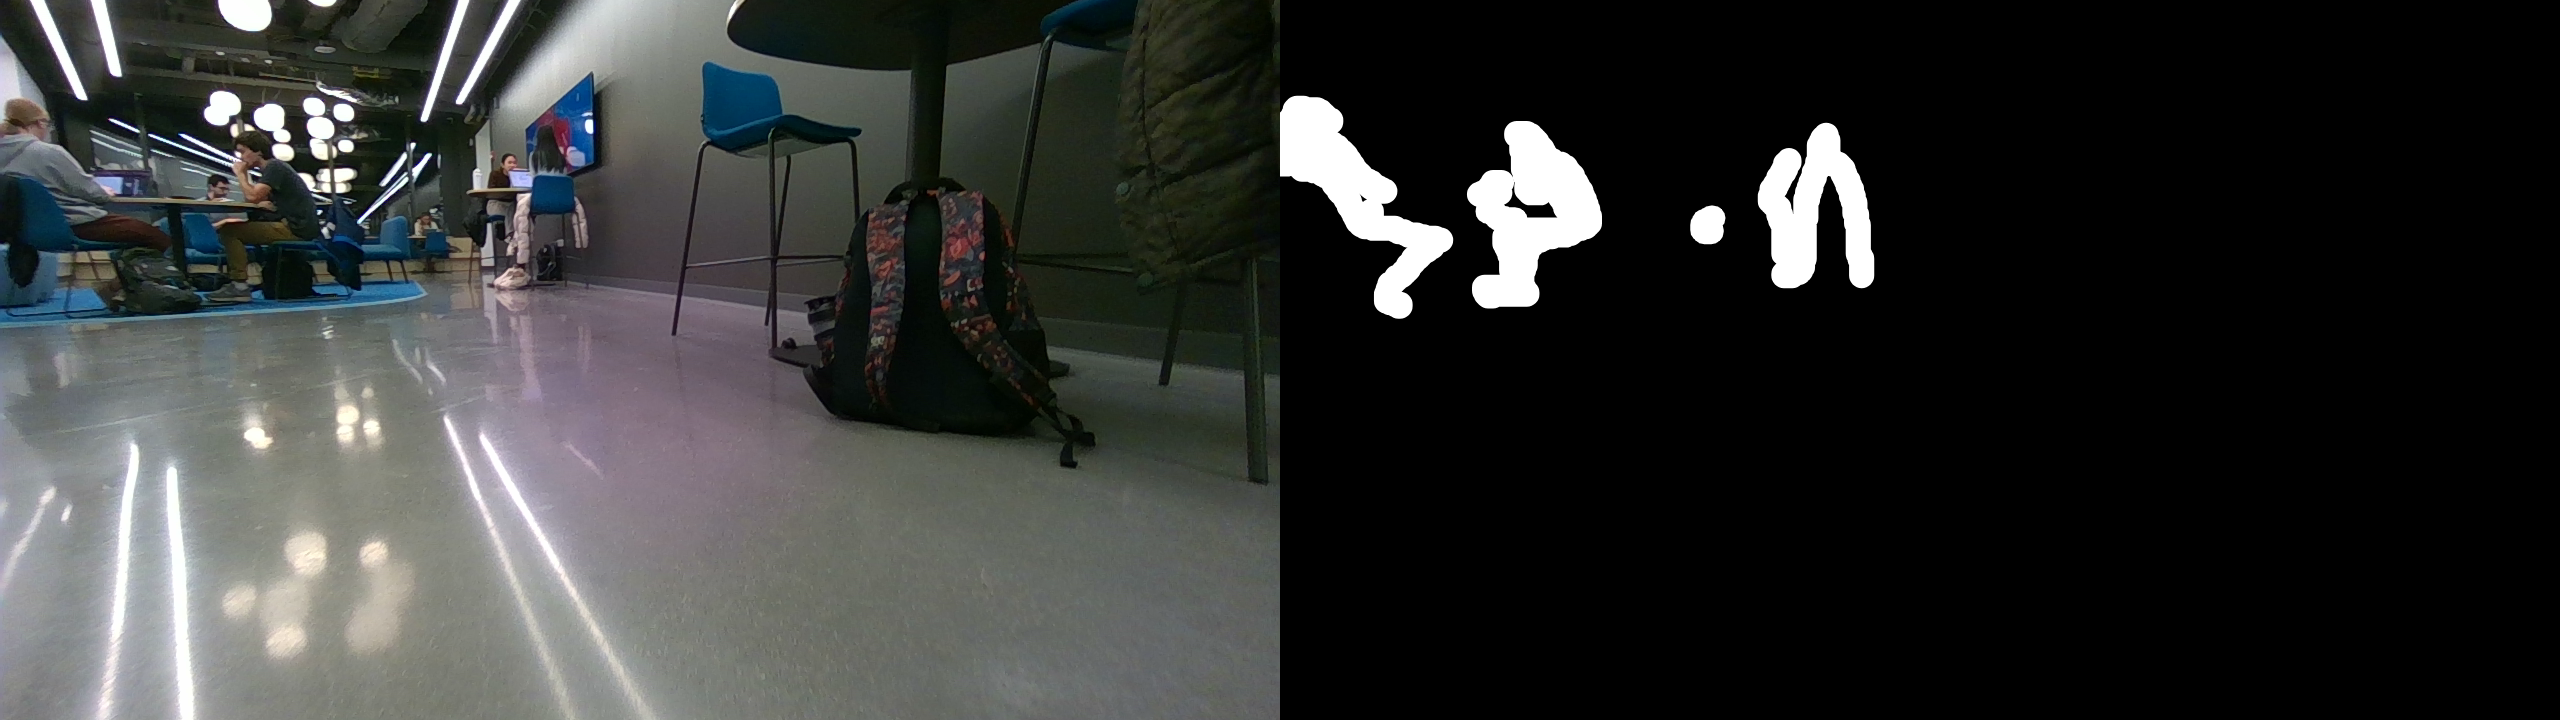

In [6]:
anno = Annotate_img("/home/kb/assitive_robotics/data/annotated_train_set")
img_original,singleton_batch,ground,immov,mov,misc = anno[53]
print("here",img_original.shape, ground.shape, immov.shape, mov.shape, misc.shape)
visualize_input(source_img=img_original,immov_ob_img=immov,mov_ob_img=mov,misc_img=misc,ground_img=ground)

In [46]:
def iou_evaluator(pred_mask,gt_mask):
    overlap = pred_mask * gt_mask
    union = (pred_mask + gt_mask) > 0
    if gt_mask.sum() == 0:
        iou = None
    else:
        iou = overlap.sum() / float(union.sum())
    return iou


In [45]:
def image_binary(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = 1 * (gray > 200)
    return gray

def create_mask(pred,c):
    pred_mask = (pred == c) * 1
    return pred_mask

In [43]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open(img_path).convert('RGB').resize((224,224))
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

NameError: name 'img_path' is not defined

## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

In [77]:
my_colors = np.array([[120,120,120],[255,0,0],[0,255,0],[0,0,255]],dtype=np.uint8) #0 immov_objects,#1 mov_objects, #2 ground, #3 misc

In [45]:
data = Images("/mnt/c/ros_converted")

In [46]:
img_original,singleton_batch = data[10,5]
output_size = img_original.shape[:2]
print(output_size)
print(img_original.shape,singleton_batch["img_data"].shape)

(720, 1280)
(720, 1280, 3) torch.Size([1, 3, 720, 1280])


In [14]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
#print(pred.shape,pred[0])
for i in range(len(pred)):
    for j in range(len(pred[i])):
        #print(pred[i][j])
        if pred[i][j] + 1 in mov_obsticles:
            #print("here")
            pred[i][j] = 1
        elif pred[i][j] + 1 in immov_obsticles:#0 is grey
            pred[i][j] = 0
        elif pred[i][j] + 1 in ground_list: #100 is green
            pred[i][j] = 2
        elif pred[i][j] + 1 in mis_list: # 15 red
            pred[i][j] = 3

#print(pred)
pred.astype()
visualize_result(img_original, pred)

NameError: name 'mov_obsticles' is not defined

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [40]:
#print(names)
obsticle_list = [1,2,5,6,8,9,11,15,16,17,18,19,20,21,23,24,25,26,28,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,56,57,58,59,63,64,65,66,68,70,71,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,96,97,98,99,100,101,102,103,104,105,106,107,108,109,11,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,67,127] #obsticles
ground_list = [3,4,7,10,12,14,22,27,29,30,47,53,54,55,60,61,62,69,74,92,95,110,129] #water is ground (22), sea(27),sand(47),PATH(53),STAIRS(54),runway(55),stairway(60),river(61),bridge(62),dirt(92),land(95),swimming(110),lake(129),earth(14)
mis_list = [13] #person
mov_obsticles = [11,16,20,21,24,25,31,34,37,40,44,68,70,72,86,99,111,120,149]
immov_obsticles = [i for i in obsticle_list if i not in mov_obsticles]
print(immov_obsticles)

[1, 2, 5, 6, 8, 9, 15, 17, 18, 19, 23, 26, 28, 32, 33, 35, 36, 38, 39, 41, 42, 43, 45, 46, 48, 49, 50, 51, 52, 56, 57, 58, 59, 63, 64, 65, 66, 71, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 94, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 67, 127]


In [16]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes:
    #print(c)
   # visualize_result(img_original, pred, c)

SyntaxError: unexpected EOF while parsing (404166261.py, line 5)

In [42]:
def inference(singleton_batch,output_size=(720,1280)):
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    #print(pred.shape)
    return pred
    

def seg_map(pred):
    for i in range(len(pred)):
        for j in range(len(pred[i])):
            if pred[i][j] + 1 in mov_obsticles:
                #print("here")
                pred[i][j] = 1
            elif pred[i][j] + 1 in immov_obsticles:#0 is grey
                pred[i][j] = 0
            elif pred[i][j] + 1 in ground_list: #100 is green
                pred[i][j] = 2
            elif pred[i][j] + 1 in mis_list: # 15 red
                pred[i][j] = 3
    return pred

In [81]:
anno = Annotate_img("/home/kb/assitive_robotics/data/annotated_train_set")
img_original,singleton_batch,ground,immov,mov,misc = anno[62]
print("here",img_original.shape, ground.shape, immov.shape, mov.shape, misc.shape)
#visualize_input(source_img=img_original,immov_ob_img=immov,mov_ob_img=mov,misc_img=misc,ground_img=ground)

here (720, 1280, 3) (720, 1280, 3) (720, 1280, 3) (720, 1280, 3) (720, 1280, 3)


In [49]:
encoded = seg_map(inference(singleton_batch))
mask = create_mask(encoded,c=0)

NameError: name 'pred' is not defined

In [69]:
def evaluate(dataset,smoothen=False,thresh=10000):
    output = pd.DataFrame(columns=["ground_iou","immov_iou","mov_iou","misc_iou"])
    total_time_2 = list()
    start = time.time()
    for i in tqdm(range(len(dataset)),total=len(dataset)):
        img_original,singleton_batch,ground,immov,mov,misc = anno[i]
        mapper = {0:immov,1:mov,2:ground,3:misc}
        mapper2 = {0:"immov_iou",1:"mov_iou",2:"ground_iou",3:"misc_iou"}
        value = dict()
        x= singleton_batch["img_data"].cpu()
        encoded = seg_map(inference(x))
        if smoothen:
            for i in range(4):
                mask= create_mask(encoded,c=i)
                encoded = smoothing(img_original.copy(),encoded,mask=mask,label=i,thresh=thresh)
        
        for j in range(4):
            pred_mask = create_mask(encoded,c=j)
            gt_mask = image_binary(mapper[j])
            iou = iou_evaluator(pred_mask,gt_mask)
            value[mapper2[j]] = iou
        output = output.append(value,ignore_index=True)
        end = time.time()
        total_time_2.append(end-start)
    return total_time_2 ,output

In [70]:
total_time_2 ,output = evaluate(dataset=anno,smoothen=True)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [68]:
total_time_2

[7.675772428512573]

In [56]:
ground_iou_mean = output["ground_iou"].mean()
immov_iou_mean = output["immov_iou"].mean()
mov_iou = output["mov_iou"].mean()
misc_iou = output["misc_iou"].mean()
total  = (ground_iou_mean + immov_iou_mean + mov_iou + misc_iou)/4
print(f"ground : {ground_iou_mean}, immov : {immov_iou_mean} , mov : {mov_iou},  misc : {misc_iou }, total : {total}")

ground : 0.7796247643186964, immov : 0.7583079001379902 , mov : 0.02984265718688352,  misc : 0.26298438149062536, total : 0.4576899257835489


(720, 1280, 3) []


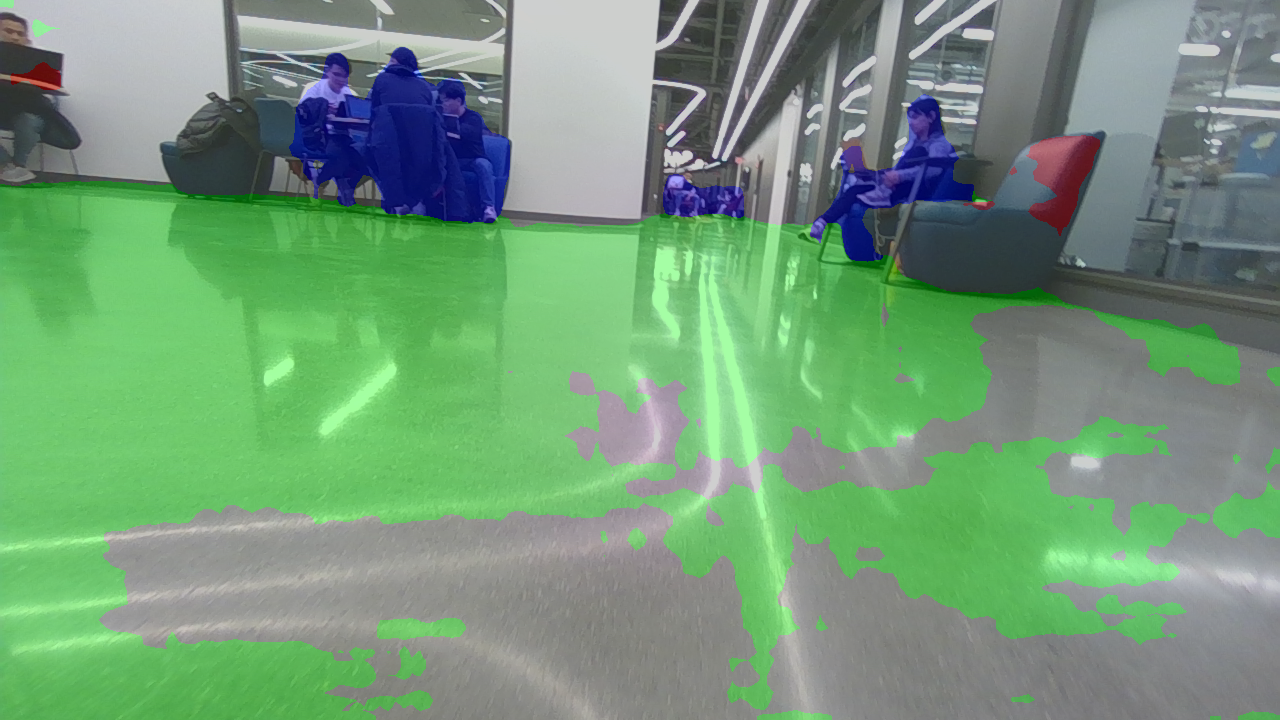

In [87]:
img_original,singleton_batch,ground,immov,mov,misc = anno[80]
encoded = seg_map(inference(singleton_batch["img_data"]))
print(img_original.shape,encoded[np.where(encoded>3)])
visualize_result(img_original, encoded, color_encode = my_colors,index=None,overlap=True)

In [52]:
def smoothing(img,encoded,tol=0, mask=None,label=0,thresh=10000):
    black_img = np.zeros(img.shape,dtype=img.dtype)
    if mask is None:
        mask = img > tol
    mask = np.array(mask, np.uint8)
    contours, _ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    #idx = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[1][0]
   
    good_countours = list()
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        cnt_area = w * h
        if cnt_area < thresh:
            continue
        good_countours.append(c)
 
    good_countours = np.array(good_countours)

    cv2.drawContours(black_img,good_countours,-1,(255,255,255),-1)
    #plt.imshow(black_img)
    black_img = image_binary(black_img)
    encoded[np.where(encoded==label)] = 0
    encoded[np.where(black_img==1)] = label
    return encoded


In [23]:
mov_count = 0
immov_count = 0
misc_count = 0
ground_count = 0
for i in range(len(anno)):
        img_original,singleton_batch,ground,immov,mov,misc = anno[i]
        if mov.sum() > 0:
            mov_count += 1
        if immov.sum() > 0:
            immov_count += 1
        if ground.sum() > 0:
            ground_count += 1
        if misc.sum() > 0:
            misc_count += 1
print(f"immov_count {immov_count}, mov_count {mov_count}, ground {ground_count}, misc {misc_count}")

immov_count 100, mov_count 59, ground 100, misc 24


In [22]:
img_original,singleton_batch,ground,immov,mov,misc = anno[74]
encoded_real = seg_map(inference(singleton_batch))

NameError: name 'segmentation_module' is not defined

/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


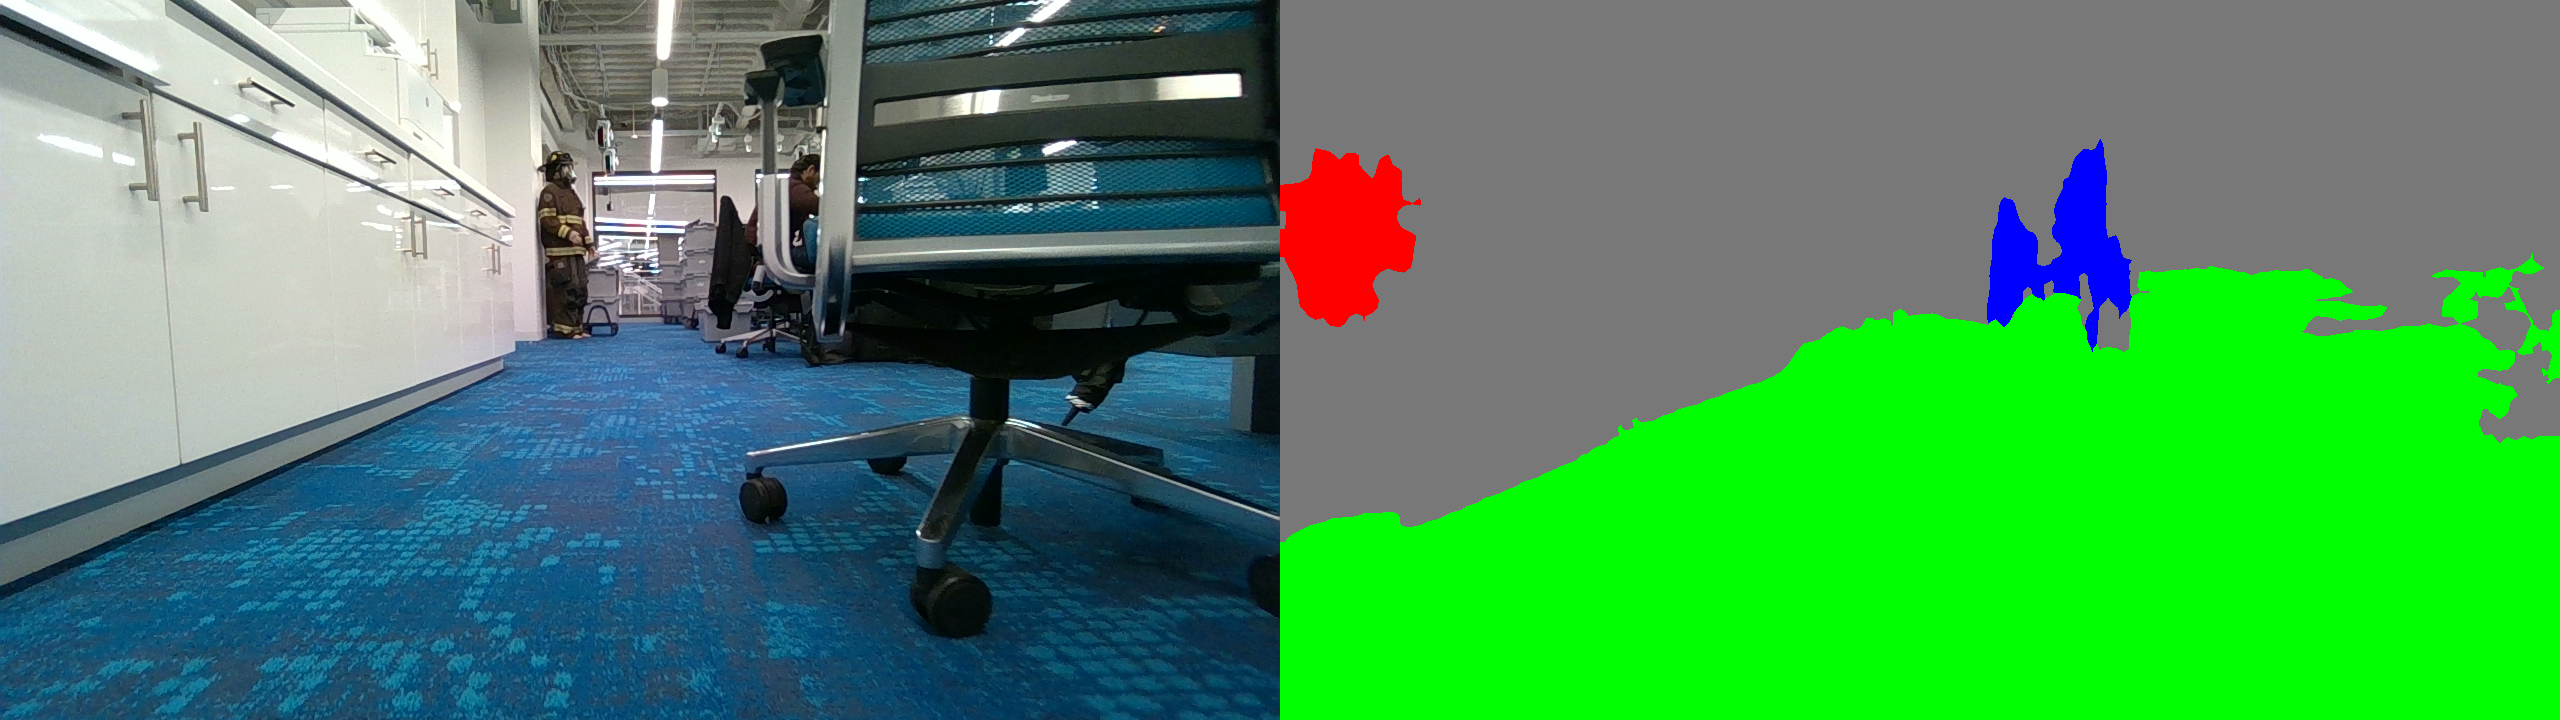

In [103]:
encoded = encoded_real.copy()
for i in range(4):
    mask= create_mask(encoded,c=i)
    encoded = smoothing(img_original.copy(),encoded,mask=mask,label=i,thresh=10000)

# for i in range(4):
  
#     mask= create_mask(encoded,c=i)
#     #(y, x) = np.where(mask == 1)
    
#     #print("before",np.max(y),np.min(y))
#     encoded = smoothing(encoded,mask=mask,label=i,thresh=100)
#     #mask= create_mask(encoded,c=i)
#     #(y, x) = np.where(mask == 1)
#     #print("after",np.max(y),np.min(y))
    
visualize_result(img_original, encoded, color_encode = my_colors,index=None,overlap=False)

In [109]:
 preprocess = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
                std=[0.229, 0.224, 0.225])  # across a large photo dataset.
        ])
my_colors = np.array([[120,120,120],[0,0,255],[0,255,0],[255,0,0]],dtype=np.uint8)
def create_video(dir,output_dir="output_2"):
    count = 0
    #fc = cv2.VideoWriter_fourcc(*"XVID")
    #video = cv2.VideoWriter("output.avi", 0, 1, (720,1280))
    os.mkdir(output_dir)
    included_extensions = [ 'png']
    images = [fn for fn in os.listdir(dir)
              if any(fn.endswith(ext) for ext in included_extensions)]

    for i in tqdm(images,total=len(images)):
        i = cv2.imread(dir + "/" + i)
        img_original = i.copy()
        i = preprocess(i)
        singleton_batch = i[None].cuda()
        encoded = seg_map(inference(singleton_batch))
        for i in range(4):
            mask= create_mask(encoded,c=i)
            encoded = smoothing(img_original.copy(),encoded,mask=mask,label=i,thresh=10000)

        output = visualize_result(img_original, encoded, color_encode = my_colors,index=None,overlap=True)
        output = np.array(output)
        print(output.shape)
        cv2.imwrite(output_dir + "/" + str(count) + ".png",output) 
        count += 1
        
#         cv2.imshow("frame",output)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        
        #video.write(output)
    #video.release()

In [110]:
create_video(dir="/mnt/c/ros_converted/9",output_dir="output_final_2")

  0%|          | 0/629 [00:00<?, ?it/s]

/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280

KeyboardInterrupt: 

In [111]:
import moviepy.video.io.ImageSequenceClip
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

image_files = []
output_dir="output_final_2"
count = 0
for img_number in range(len(os.listdir(output_dir))): 
    image_files.append(output_dir + '/' + str(count) + '.png')
    count += 1

fps = 20
#print(image_files)

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_new_video.mp4',fps=fps)

Moviepy - Building video my_new_video.mp4.
Moviepy - Writing video my_new_video.mp4



Moviepy - Done !
Moviepy - video ready my_new_video.mp4


In [ ]:
import torch.onnx
import torchvision.models as models

# Load a pretrained PyTorch model
model = models.resnet18(pretrained=True)
model.eval()

# Input dummy data
img_original,singleton_batch,ground,immov,mov,misc = anno[62]
dummy_input = singleton_batch["img_data"]
print(dummy_input)
# Export the model to ONNX format
onnx_path = "model.onnx"
torch.onnx.export(segmentation_module, dummy_input, onnx_path, verbose=True,opset_version=12, input_names=['input'], output_names=['output'])

/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[[[ 0.9132,  0.9132,  0.9303,  ..., -0.0801, -0.0629, -0.0629],
          [ 0.8618,  0.9132,  0.8276,  ..., -0.0801, -0.0801, -0.0801],
          [ 0.8276,  0.8618,  0.8618,  ..., -0.0801, -0.0801, -0.0801],
          ...,
          [ 0.0227,  0.0398,  0.0056,  ...,  0.1083,  0.1083,  0.0912],
          [ 0.0227,  0.0227,  0.0056,  ...,  0.1083,  0.1083,  0.0912],
          [ 0.0569,  0.0569,  0.0056,  ..., -0.0287, -0.0287, -0.0287]],

         [[ 1.0630,  1.0630,  1.0980,  ...,  0.0826,  0.1001,  0.1001],
          [ 1.0105,  1.0630,  0.9930,  ...,  0.0826,  0.0826,  0.0826],
          [ 1.0280,  1.0630,  1.0805,  ...,  0.0826,  0.0826,  0.0826],
          ...,
          [-0.0574, -0.0399, -0.0574,  ...,  0.2227,  0.2227,  0.2052],
          [-0.0224, -0.0224, -0.0224,  ...,  0.2227,  0.2227,  0.2052],
          [ 0.0126,  0.0126, -0.0224,  ...,  0.0826,  0.0826,  0.0826]],

         [[ 1.5942,  1.5942,  1.5768,  ...,  0.4788,  0.4962,  0.4962],
          [ 1.5768,  1.6291,  

In [6]:
import torch
from torch2trt import torch2trt
#import torch_tensorrt
import tensorrt 

img_original,singleton_batch,ground,immov,mov,misc = anno[62]
#segmentation_module = segmentation_module(segSize=(720,1280))
x= singleton_batch["img_data"]
#x = torch.ones((1, 3, 720, 1280))
model_trt = torch2trt(segmentation_module,[x])

[12/04/2023-13:02:30] [TRT] [E] 1: [virtualMemoryBuffer.cpp::resizePhysical::132] Error Code 1: Cuda Driver (invalid argument)
[12/04/2023-13:02:31] [TRT] [E] 2: [globWriter.cpp::HybridGlobWriter::397] Error Code 2: OutOfMemory (no further information)


In [8]:
import openvino
import ngraph as ng
import time


/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ngraph/helpers.py:9: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino.inference_engine import IENetwork  # type: ignore
/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: OpenVINO nGraph Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  


In [9]:
x= singleton_batch["img_data"]
ov_model = openvino.convert_model(segmentation_module,example_input = x)
print("Done ov_model")
openvino.save_model(ov_model,"animal_clf.xml")
print("model saved")

Done ov_model
model saved


In [16]:
torch.save(segmentation_module.state_dict(), "normal_model.ckpt")

In [17]:
import sys
sys. getsizeof(ov_model)
sys.getsizeof(segmentation_module)
#3.88 mb quantized model , #8.72 mb normal model

64

In [20]:
compiled_model = openvino.compile_model(ov_model)

In [53]:
import time
def inference_vino(singleton_batch,output_size=(720,1280)):
    with torch.no_grad():
        scores = compiled_model(singleton_batch)
    scores = torch.Tensor(list(scores.values())[0])
    #print(scores)
    _, pred = torch.max(scores, dim=1)
    
    pred = pred.cpu()[0].numpy()
    #print(pred.shape)
    return pred

def evaluate_openvino(dataset,smoothen=False,thresh=10000):
    output = pd.DataFrame(columns=["ground_iou","immov_iou","mov_iou","misc_iou"])
    total_time = list()
    start = time.time()
    for i in tqdm(range(len(dataset)),total=len(dataset)):
        img_original,singleton_batch,ground,immov,mov,misc = anno[i]
        x= singleton_batch["img_data"].cpu()
        mapper = {0:immov,1:mov,2:ground,3:misc}
        mapper2 = {0:"immov_iou",1:"mov_iou",2:"ground_iou",3:"misc_iou"}
        value = dict()
        encoded = seg_map(inference_vino(x))
        if smoothen:
            for i in range(4):
                mask= create_mask(encoded,c=i)
                encoded = smoothing(img_original.copy(),encoded,mask=mask,label=i,thresh=thresh)
        
        for j in range(4):
            pred_mask = create_mask(encoded,c=j)
            gt_mask = image_binary(mapper[j])
            iou = iou_evaluator(pred_mask,gt_mask)
            value[mapper2[j]] = iou
        output = output.append(value,ignore_index=True)
        end = time.time()
        total_time.append(end-start)
    return output,total_time

In [54]:
openvino_output,openvino_time = evaluate_openvino(anno,smoothen=True,thresh=10000)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/kb/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [49]:
openvino_output

ground_iou  immov_iou   mov_iou  misc_iou
0     0.830269   0.795033  0.000000       NaN
1     0.832188   0.795302  0.002131  0.244955
2     0.874591   0.839568  0.000000       NaN
3     0.838560   0.850781  0.006509       NaN
4     0.566271   0.670121  0.010975       NaN
..         ...        ...       ...       ...
95    0.565007   0.576229  0.095144       NaN
96    0.723173   0.685490  0.096626  0.404645
97    0.811588   0.757380  0.013022       NaN
98    0.849293   0.885583  0.000000       NaN
99    0.460323   0.638480       NaN       NaN

[100 rows x 4 columns]

In [55]:
ground_iou_mean = openvino_output["ground_iou"].mean()
immov_iou_mean = openvino_output["immov_iou"].mean()
mov_iou = openvino_output["mov_iou"].mean()
misc_iou = openvino_output["misc_iou"].mean()
total  = (ground_iou_mean + immov_iou_mean + mov_iou + misc_iou)/4
print(f"ground : {ground_iou_mean}, immov : {immov_iou_mean} , mov : {mov_iou},  misc : {misc_iou }, total : {total}")

ground : 0.7795319189819971, immov : 0.7581989119260537 , mov : 0.029847310350955756,  misc : 0.26297391228252104, total : 0.4576380133853819


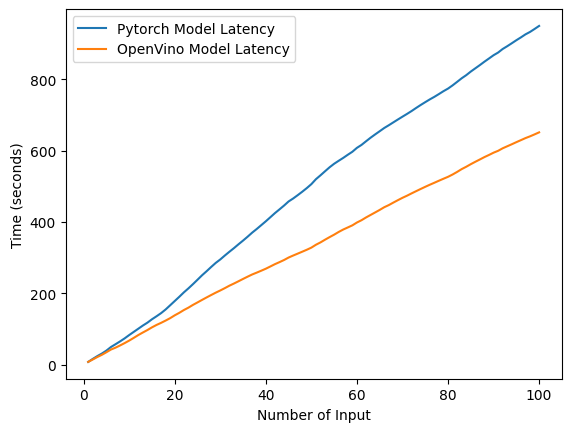

In [73]:
plt.plot(list(range(1,101)),total_time_2,label='Pytorch Model Latency')
plt.plot(list(range(1,101)),openvino_time,label='OpenVino Model Latency')
plt.xlabel("Number of Input")
plt.ylabel("Time (seconds)")
plt.legend()